In [1]:
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.varmax import VARMAX
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# Pg 203
macro_econ_data = sm.datasets.macrodata.load_pandas().data
macro_econ_data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


# VARMAX 

In [3]:
# Pg 205
ad_fuller_result_1 = adfuller(macro_econ_data['realdpi'])

print('realdpi')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(macro_econ_data['realcons'])

print('realcons')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

realdpi
ADF Statistic: 2.986025351954683
p-value: 1.0

---------------------

realcons
ADF Statistic: 1.5499123380509614
p-value: 0.9976992503412904


In [4]:
# Pg 205
ad_fuller_result_1 = adfuller(macro_econ_data['realdpi'].diff()[1:])

print('realdpi')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(macro_econ_data['realcons'].diff()[1:])

print('realcons')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

realdpi
ADF Statistic: -8.864893340673008
p-value: 1.4493606159108096e-14

---------------------

realcons
ADF Statistic: -4.204306080845247
p-value: 0.0006479282158627571


## d=1, D=0. No seasonal pattern detected either. Aligned

In [5]:
# Combinations of p,q
p = range(0, 4, 1)
q = range(0, 4, 1)

combinations = product(p, q)
order_list = list(combinations)

In [6]:
# Pg 206
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.varmax import VARMAX

def optimize_VARMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try:
            model = VARMAX(endog, exog, order=(order[0], order[1])).fit(dips=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

#### Will do differencing on the exog as well

In [8]:
# Pg 206
endog = macro_econ_data[['realdpi', 'realcons']]
exog = macro_econ_data[['realinv', 'realgovt', 'cpi', 'm1', 'tbilrate', 'unemp', 'pop', 'infl', 'realint']]

endog_diff = macro_econ_data[['realdpi', 'realcons']].diff()[1:]
exog_diff = exog.diff()[1:]

endog_train = endog_diff[:162]      # len = 162
exog_train = exog_diff[:162]        # len = 162

endog_test = endog_diff[162:]       # len = 40
exog_test = exog_diff[162:]         # len = 40

result_df = optimize_VARMAX(endog_train, exog_train, order_list)
result_df[:20]

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(0, 3)",3093.195221
1,"(3, 2)",3104.121953
2,"(1, 3)",3108.197404
3,"(3, 3)",3108.982598
4,"(3, 1)",3109.622776
5,"(3, 0)",3111.217696
6,"(2, 2)",3112.105619
7,"(2, 3)",3113.835600
8,"(2, 1)",3114.772605
9,"(0, 2)",3116.238591


exog = macro_econ_data[['realinv', 'realgovt', 'cpi', 'm1', 'tbilrate', 'unemp', 'pop', 'infl', 'realint']]  
	(p,q)	AIC  
0	(0, 3)	3093.195221  
1	(3, 2)	3104.121953   
2	(1, 3)	3108.197404   
3	(3, 3)	3108.982598    
4	(3, 1)	3109.622776   
5	(3, 0)	3111.217696    
6	(2, 2)	3112.105619   
7	(2, 3)	3113.835600  
8	(2, 1)	3114.772605   
9	(0, 2)	3116.238591   
10	(2, 0)	3117.395240  
11	(0, 1)	3118.888946   
12	(1, 0)	3122.149902  
13	(1, 2)	3125.873613   
14	(1, 1)	3127.540216  


Let's pick the first one, VARMAX(endog_train, exog_train, order=(0,3))  

In [9]:
# Pg 207
print('realcons Granger-causes realdpi?\n')
print('------------------')
granger_1 = grangercausalitytests(macro_econ_data[['realdpi', 'realcons']].diff()[1:], [3])  # coefficient = max order of the model

print('\nrealdpi Granger-causes realcons?\n')
print('------------------')
granger_2 = grangercausalitytests(macro_econ_data[['realcons', 'realdpi']].diff()[1:], [3])  # coefficient = max order of the model

realcons Granger-causes realdpi?

------------------

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.2363  , p=0.0000  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=28.7191 , p=0.0000  , df=3
likelihood ratio test: chi2=26.8268 , p=0.0000  , df=3
parameter F test:         F=9.2363  , p=0.0000  , df_denom=192, df_num=3

realdpi Granger-causes realcons?

------------------

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8181  , p=0.0403  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=8.7625  , p=0.0326  , df=3
likelihood ratio test: chi2=8.5751  , p=0.0355  , df=3
parameter F test:         F=2.8181  , p=0.0403  , df_denom=192, df_num=3


In [10]:
# Pg 207
best_model = VARMAX(endog_train, exog_train, order=(0,3))
best_model_fit = best_model.fit(disp=False)

print(best_model_fit.summary())

                              Statespace Model Results                             
Dep. Variable:     ['realdpi', 'realcons']   No. Observations:                  162
Model:                             VMAX(3)   Log Likelihood               -1511.598
                               + intercept   AIC                           3093.195
Date:                     Tue, 17 Feb 2026   BIC                           3201.261
Time:                             15:43:27   HQIC                          3137.072
Sample:                                  0                                         
                                     - 162                                         
Covariance Type:                       opg                                         
Ljung-Box (L1) (Q):             0.24, 0.12   Jarque-Bera (JB):          46.35, 4.47
Prob(Q):                        0.62, 0.73   Prob(JB):                   0.00, 0.11
Heteroskedasticity (H):         4.08, 2.49   Skew:                       0.0

### Residuals Analysis 

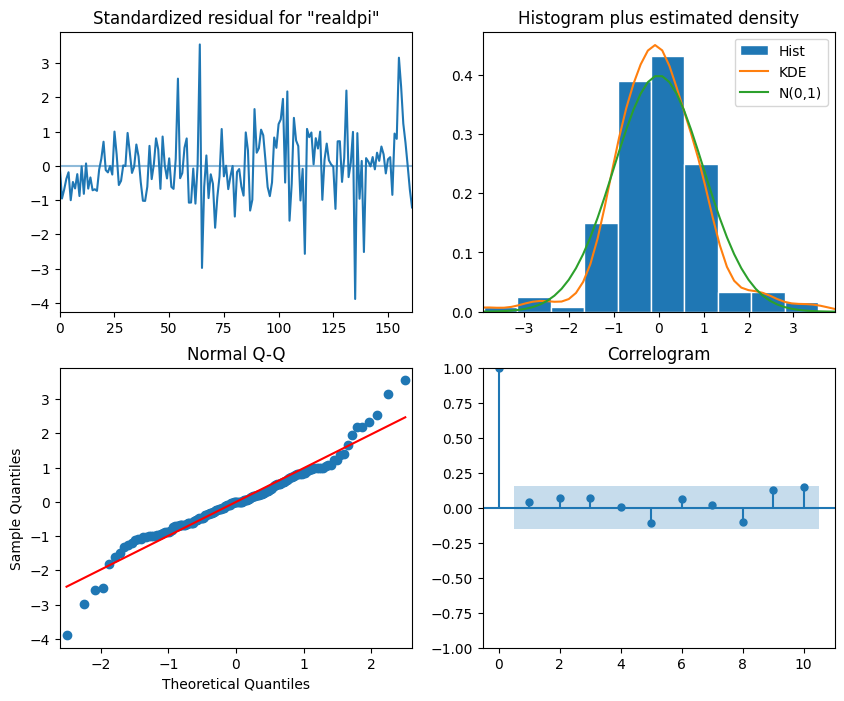

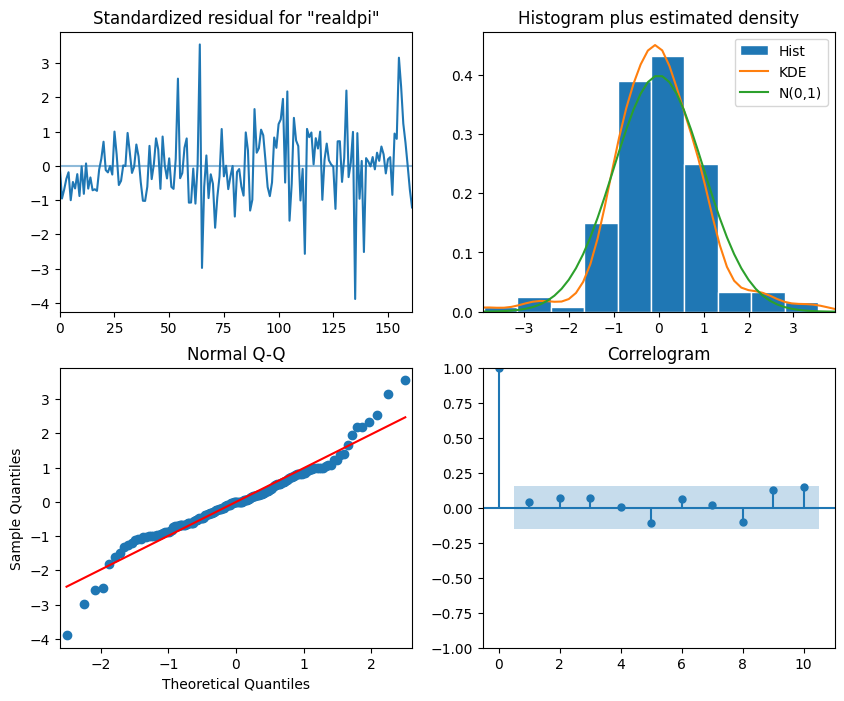

In [11]:
# Figure 10.4 in pg 208
# realdpi
best_model_fit.plot_diagnostics(figsize=(10,8), variable=0)

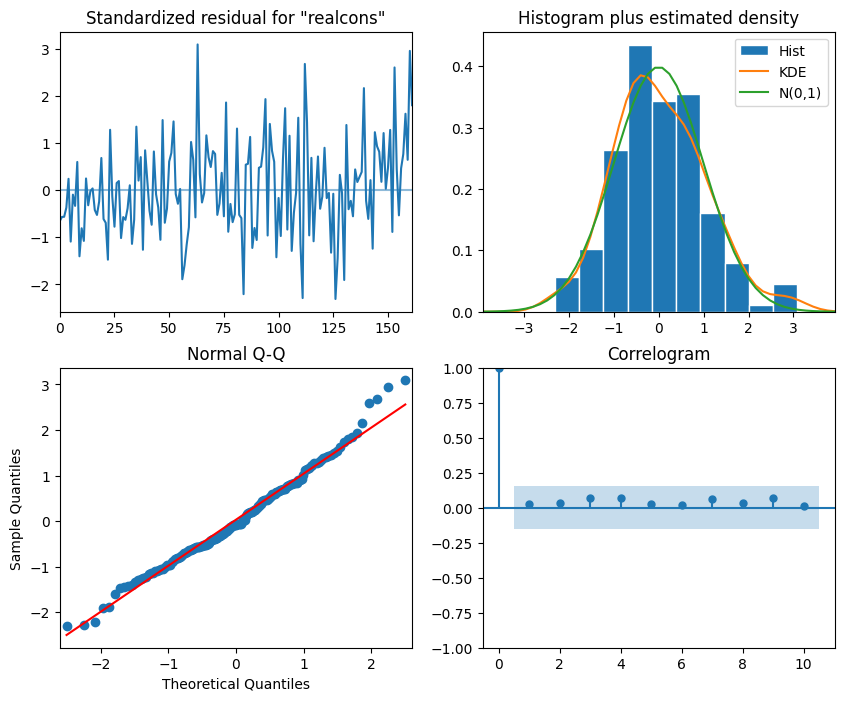

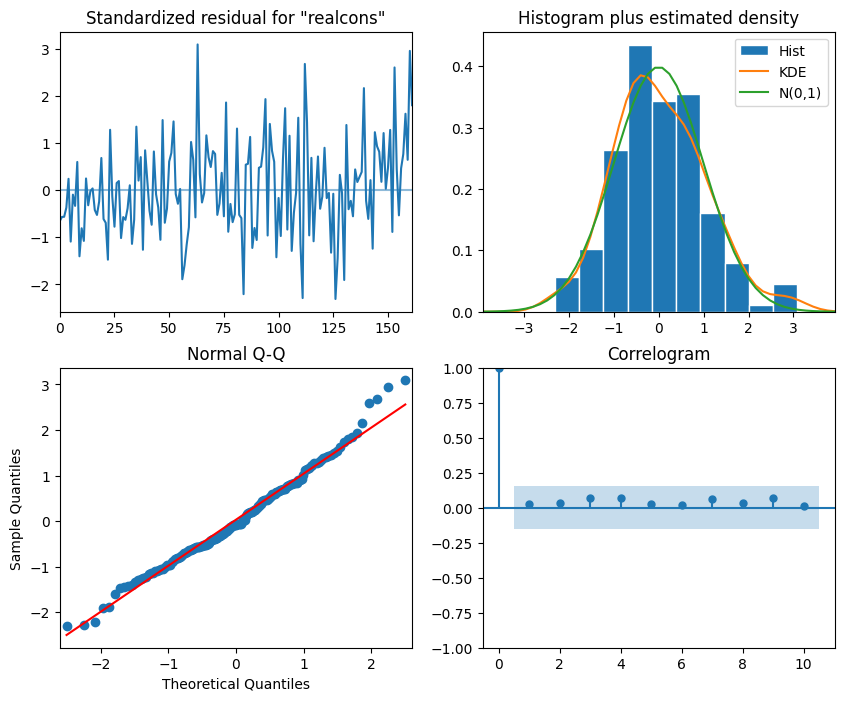

In [12]:
# Figure 10.5 in pg 209
# realcons
best_model_fit.plot_diagnostics(figsize=(10,8), variable=1)

In [13]:
# Pg 209
# realgdp_residuals = best_model_fit.resid['realdpi']

# lbvalue, pvalue = acorr_ljungbox(realgdp_residuals, np.arange(1, 11, 1))

# print(pvalue)

In [14]:
realgdp_residuals = best_model_fit.resid['realdpi']
lb_dataframe = acorr_ljungbox(realgdp_residuals, np.arange(1, 11, 1))
lb_dataframe

,lb_stat,lb_pvalue
1,0.252710,0.615173
2,1.108070,0.574626
3,2.000026,0.572401
4,2.010408,0.733845
5,3.984109,0.551706
6,4.687274,0.584501
7,4.735710,0.692179
8,6.416032,0.600736
9,9.250341,0.414494
10,13.248628,0.210101


In [15]:
# Pg 210
# realcons_residuals = best_model_fit.resid['realcons']

# lbvalue, pvalue = acorr_ljungbox(realcons_residuals, np.arange(1, 11, 1))

# print(pvalue)

In [16]:
realcons_residuals = best_model_fit.resid['realcons']
lb_dataframe = acorr_ljungbox(realcons_residuals, np.arange(1, 11, 1))
lb_dataframe

,lb_stat,lb_pvalue
1,0.232724,0.629511
2,0.624839,0.731675
3,1.887695,0.596040
4,4.902372,0.297462
5,5.982396,0.307936
6,8.401790,0.210120
7,8.929432,0.257762
8,9.006144,0.341778
9,10.192616,0.335118
10,10.551598,0.393502


### Residuals Analysis successful

In [17]:
# Pg 210-211
def rolling_forecast(endog: Union[pd.Series, list], exog: Union[pd.Series, list], train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    
    if method == 'VARMAX':

        realdpi_pred_VARMAX = []
        realcons_pred_VARMAX = []
        
        for i in range(train_len, total_len, window):
            model = VARMAX(endog[:i], exog[:i], order=(0,3))
            res = model.fit(disp=False)
            predictions = res.get_prediction(start=i, end=i+window-1, exog=exog[i:i+window])  # only out-of-sample prediction
            
            oos_pred_realdpi = predictions.predicted_mean.iloc[-window:]['realdpi']
            oos_pred_realcons = predictions.predicted_mean.iloc[-window:]['realcons']
            
            realdpi_pred_VARMAX.extend(oos_pred_realdpi)
            realcons_pred_VARMAX.extend(oos_pred_realcons)
        
        return realdpi_pred_VARMAX[:horizon], realcons_pred_VARMAX[:horizon]  
    
    elif method == 'last':
        realdpi_pred_last = []
        realcons_pred_last = []
        
        for i in range(train_len, total_len, window):
            
            realdpi_last = endog[:i].iloc[-1]['realdpi']
            realcons_last = endog[:i].iloc[-1]['realcons']
            
            realdpi_pred_last.extend(realdpi_last for _ in range(window))
            realcons_pred_last.extend(realcons_last for _ in range(window))
            
        return realdpi_pred_last[:horizon], realcons_pred_last[:horizon]  

In [18]:
# Pg 211
TRAIN_LEN = len(endog_train)
HORIZON = len(endog_test)
WINDOW = 1

#realdpi_pred_VAR, realcons_pred_VAR = recursive_forecast(endog_diff, TRAIN_LEN, HORIZON, WINDOW, 'VARMAX')
realdpi_pred_VARMAX, realcons_pred_VARMAX = rolling_forecast(endog_diff, exog_diff, TRAIN_LEN, HORIZON, WINDOW, 'VARMAX')

*****************************************************************

Inverting transformation (differencing)

Instead of:

In [19]:
# # Pg 211
# test = endog[163:]

# test['realdpi_pred_VAR'] = pd.Series()
# test['realdpi_pred_VAR'] = endog.iloc[162]['realdpi'] + np.cumsum(realdpi_pred_VAR)

# test['realcons_pred_VAR'] = pd.Series()
# test['realcons_pred_VAR'] = endog.iloc[162]['realcons'] + np.cumsum(realcons_pred_VAR)

# test

Let's do:

In [20]:
test = endog[163:] # from index 163 to index 202

In [21]:
# endog.iloc[162:]['realdpi'].head()

In [22]:
realdpi_pred_VARMAX_diff = pd.Series(realdpi_pred_VARMAX, index=range(162,202))  # len = 40
realcons_pred_VARMAX_diff = pd.Series(realcons_pred_VARMAX, index=range(162,202))

In [23]:
# pred_VAR_diff.head()

In [24]:
# pred_VAR_diff.tail()

In [25]:
zz_realdpi = endog.iloc[162:]['realdpi'] + realdpi_pred_VARMAX_diff
zz_realcons = endog.iloc[162:]['realcons'] + realcons_pred_VARMAX_diff

In [26]:
# zz.head()

In [27]:
# zz.tail()

In [28]:
zzz_realdpi = zz_realdpi.shift(periods=1).dropna()  
zzz_realcons = zz_realcons.shift(periods=1).dropna()  

In [29]:
# zzz.head()

In [30]:
# zzz.tail()

In [31]:
test['realdpi_pred_VARMAX'] = zzz_realdpi
test['realcons_pred_VARMAX'] = zzz_realcons

*****************************************************************

In [32]:
# Pg 211
#realdpi_pred_last, realcons_pred_last = recursive_forecast(endog, TRAIN_LEN, HORIZON, WINDOW, 'last')
realdpi_pred_last, realcons_pred_last = rolling_forecast(endog, exog, TRAIN_LEN, HORIZON, WINDOW, 'last')

test['realdpi_pred_last'] = realdpi_pred_last
test['realcons_pred_last'] = realcons_pred_last

# test

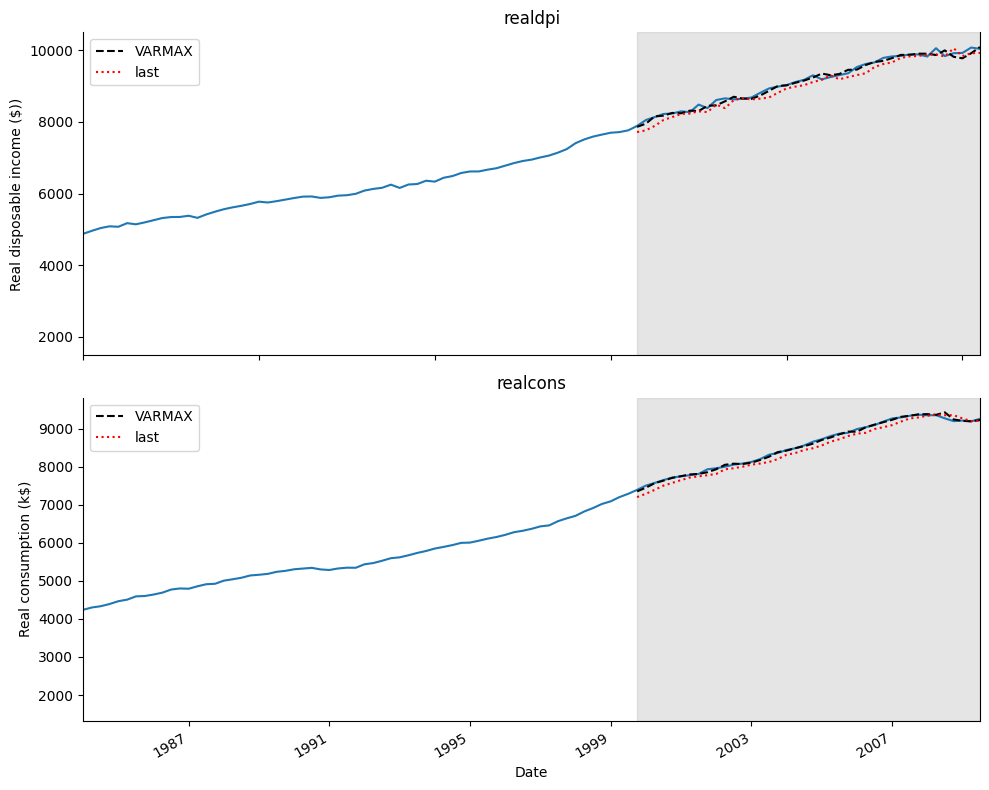

In [33]:
# Figure 10.6 in pg 212

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,8))

ax1.plot(macro_econ_data['realdpi'])
ax1.plot(test['realdpi_pred_VARMAX'], 'k--', label='VARMAX')
ax1.plot(test['realdpi_pred_last'], 'r:', label='last')
ax1.set_xlabel('Date')
ax1.set_ylabel('Real disposable income ($))')
ax1.set_title('realdpi')
ax1.spines['top'].set_alpha(0)
ax1.axvspan(163, 202, color='#808080', alpha=0.2)
ax1.set_xlim(100, 202)
ax1.legend(loc=2)

ax2.plot(macro_econ_data['realcons'])
ax2.plot(test['realcons_pred_VARMAX'], 'k--', label='VARMAX')
ax2.plot(test['realcons_pred_last'], 'r:', label='last')
ax2.set_xlabel('Date')
ax2.set_ylabel('Real consumption (k$)')
ax2.set_title('realcons')
ax2.spines['top'].set_alpha(0)
ax2.axvspan(163, 202, color='#808080', alpha=0.2)
ax2.set_xlim(100, 202)
ax2.legend(loc=2)

plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))
plt.xlim(100, 202)

fig.autofmt_xdate()
plt.tight_layout()


In [34]:
# Pg 213
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [35]:
# Pg 213
mape_realdpi_VAR = mape(test['realdpi'], test['realdpi_pred_VARMAX'])
mape_realdpi_last = mape(test['realdpi'], test['realdpi_pred_last'])

mape_realcons_VAR = mape(test['realcons'], test['realcons_pred_VARMAX'])
mape_realcons_last = mape(test['realcons'], test['realcons_pred_last'])

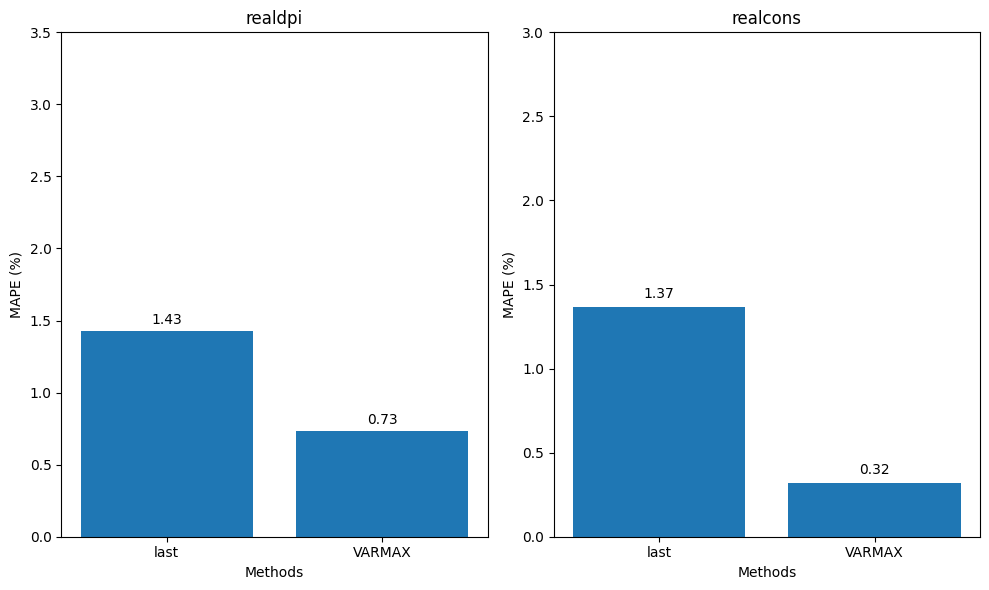

In [36]:
# Figure 10.7 in pg 213

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

x = ['last', 'VARMAX']
y1 = [mape_realdpi_last, mape_realdpi_VAR]
y2 = [mape_realcons_last, mape_realcons_VAR]

ax1.bar(x, y1)
ax1.set_xlabel('Methods')
ax1.set_ylabel('MAPE (%)')
ax1.set_title('realdpi')
ax1.set_ylim(0, 3.5)

ax2.bar(x,y2)
ax2.set_xlabel('Methods')
ax2.set_ylabel('MAPE (%)')
ax2.set_title('realcons')
ax2.set_ylim(0, 3)

for index, value in enumerate(y1):
    ax1.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')
    
for index, value in enumerate(y2):
    ax2.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')

plt.tight_layout()
